In [ ]:
import os
os.chdir('/container/mount/point/')

import pandas as pd
import numpy as np

import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm
from scipy.stats import mannwhitneyu
from plotly.subplots import make_subplots


from rpy2.robjects.packages import importr

from utils.helper import generate_taxa_dict
from utils.helper import perform_bh_correction_and_filter, calculate_obs_stat_and_pvalues
from utils.preprocessing import filter_and_process_asv_table
from utils.pair_matching import discrepancyMatrix, construct_network, process_matched_pairs

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

# Overview of Differential Abundance Analysis
This notebook investigates differential abundance (DA) of microbial taxa across sample groups. The workflow includes:
- Loading and preprocessing microbiome and metadata
- Performing statistical tests to identify differentially abundant taxa
- Visualizing DA results with plots and tables
- Interpreting findings in the context of biological or clinical variables
Each section below is accompanied by code and explanations to guide the reader through the analysis steps.

In [2]:
def truncate_name(row):
    
    index_value = row.name  # Get the index value
    name_value = row['name']  # Get the name value
    
    # Find the position of the index in the name and keep everything up to it
    truncated_name = name_value.split(index_value)[0] + index_value if index_value in name_value else name_value
    return truncated_name

In [3]:
utils = importr('utils')
devtools = importr('devtools')
linda = importr("LinDA")

base = importr('base')
BiocManager = importr('BiocManager')
DescTools = importr('DescTools')
ancom_bc = importr('ANCOMBC')
phyloseq = importr('phyloseq')

In [4]:
with open('data/taxa_dict_ige.pickle', 'rb') as file:
    counts_dict = pkl.load(file)

In [5]:
for lvl in ['phylum', 'class', 'family', 'order', 'genus', 'species', 'ASV']:
    print(lvl, counts_dict[lvl].shape[0])

phylum 17
class 26
family 212
order 87
genus 1345
species 6302
ASV 6958


In [6]:
taxa = pd.read_csv('data/taxonomy_clean.csv', sep=',', index_col=0)

In [7]:
control_sample_df = pd.read_csv("data/control_samples.csv", sep=",", index_col=0, low_memory=False)

control_sample_ids = control_sample_df.index.astype(str)

### Raw data

## Data Loading and Preprocessing
In this section, we load the microbiome count tables and associated metadata. Preprocessing steps may include filtering, normalization, and transformation of the data to ensure robust and accurate differential abundance analysis. Proper data preparation is essential for meaningful statistical testing.

In [8]:
raw_counts = counts_dict['ASV']

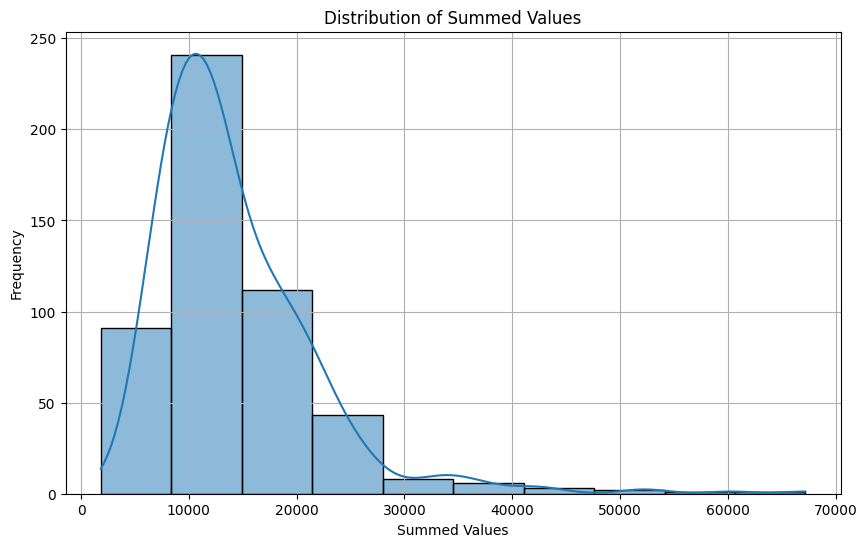

In [9]:
sum_values = list(raw_counts.sum(axis=0).sort_values(ascending=False))

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(sum_values, bins=10, kde=True)
plt.title('Distribution of Summed Values')
plt.xlabel('Summed Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Each cluster vs. Control samples

## Differential Abundance Testing
This section applies statistical methods to identify microbial taxa that are differentially abundant between groups. Common approaches include non-parametric tests, generalized linear models, or specialized tools for compositional data. The results highlight taxa whose abundance patterns are associated with the variable of interest.

In [8]:
all_samples = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col='u3_16s_id', low_memory=False)
ige_samples = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col =0, low_memory=False)
control_samples = pd.read_csv("data/control_samples.csv", sep=",", index_col =0, low_memory=False)
taxa = pd.read_csv('data/taxonomy_clean.csv', sep=',', index_col=0)
asv = pd.read_csv(str("data/feature_table.tsv"), index_col=0, sep='\t')
cluster_df = pd.read_csv("data/cluster_df_latent.csv", sep=",", index_col =0, low_memory=False)
covariates = pd.read_csv("data/kora_full_preprocessed.csv", sep=",", index_col='u3_16s_id', low_memory=False)

print("Shape of Test IgE DataFrame:", ige_samples.shape)
print("Shape of NO IgE DataFrame:", control_samples.shape)
print("Shape of Taxa DataFrame:", taxa.shape)
print("Shape of ASVs DataFrame:", asv.shape)
# print("Cluster Value Counts:\n", cluster_df['cluster'].value_counts())

single_multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) >= 1].tolist()

single = all_samples.index[all_samples.astype(bool).sum(axis=1) == 1].tolist()
multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) > 1].tolist()
no_allergy = all_samples.index[all_samples.astype(bool).sum(axis=1) == 0].tolist()

row_sums = ige_samples.sum(axis=1)
ige_score_vector = row_sums.sort_values(ascending=False)
score_order = ige_score_vector.index
score_order = [str(i) for i in score_order]

high_score = ige_score_vector[ige_score_vector > 15].index.tolist()
medium_score = ige_score_vector[(ige_score_vector <= 15) & (ige_score_vector > 5)].index.tolist()
low_score = ige_score_vector[ige_score_vector <= 5].index.tolist()


allergy_status = {
    "any_ige": single_multiple,
    "single": single,
    "multiple": multiple,
    "high_score": high_score,
    "medium_score": medium_score,
    "low_score": low_score
    # "no_allergy": no_allergy
    }

Shape of Test IgE DataFrame: (275, 104)
Shape of NO IgE DataFrame: (233, 104)
Shape of Taxa DataFrame: (15170, 8)
Shape of ASVs DataFrame: (15170, 2034)


In [9]:
cluster_df = pd.read_csv("data/cluster_df_latent.csv", sep=",", index_col =0, low_memory=False)

cluster_df['sample_id'] = cluster_df.index

for cluster in cluster_df['cluster'].unique():
    allergy_status[cluster] = cluster_df.loc[cluster_df['cluster'] == cluster, 'sample_id'].tolist()
    
for key in allergy_status:
    print(f"{key.replace('_', ' ').title()} samples:", len(allergy_status[key]))

Any Ige samples: 275
Single samples: 47
Multiple samples: 228
High Score samples: 57
Medium Score samples: 110
Low Score samples: 108
A samples: 12
B samples: 24
C samples: 26
D samples: 45
E samples: 22
F samples: 10
I samples: 74
H samples: 40
G samples: 22


### LinDA

## Visualization and Interpretation of DA Results
Visualization of differential abundance results helps to interpret which taxa are significantly associated with the groups of interest. Plots such as volcano plots, bar charts, or heatmaps can highlight effect sizes, significance, and patterns across taxa. These visualizations support biological interpretation and hypothesis generation.

In [10]:
result_dict = dict()
freq_threshold = 0
seed = 42
pair_matching = False

In [11]:
for cluster in tqdm(allergy_status.keys(), desc="Processing clusters"):

    print(f"------------------------- Cluster: {cluster} ------------------------- \n")
    
    cluster_ige_samples = ige_samples[ige_samples.index.isin(allergy_status[cluster])]
    control_samples = control_samples[cluster_ige_samples.columns]

    combined_data = pd.concat([cluster_ige_samples, control_samples])[cluster_ige_samples.columns]

    print("Shape of concatenated data:", combined_data.shape)

    test_samples = combined_data.loc[combined_data.index.isin(cluster_ige_samples.index)]
    ctlr_samples = combined_data.loc[combined_data.index.isin(control_samples.index)]
    
    if pair_matching:

        #################### PAIR-MATCHING ##############################
        
        test_samples_new_column = pd.DataFrame({'W': np.ones(test_samples.shape[0])})
        ctlr_samples_new_column = pd.DataFrame({'W': np.zeros(ctlr_samples.shape[0])})
        
        test_samples = pd.concat([test_samples.reset_index(drop=False), test_samples_new_column], axis=1)
        ctlr_samples = pd.concat([ctlr_samples.reset_index(drop=False), ctlr_samples_new_column], axis=1)

        df = pd.concat([test_samples, ctlr_samples])
        df.set_index('u3_16s_id', inplace=True)

        ### join with covariates and drop missing samples
        df = df.join(covariates[['u3csex']])

        # ### drop samples where we don't know age, sex or BMI
        # df.dropna(inplace=True)

        df["is_treated"] = df["W"].astype(bool)
        df["pair_nb"] = np.nan

        # Set the thresholds for each covariate (p), default is Inf (i.e. no matching)
        thresholds =  np.empty((df.shape[1], ))
        thresholds[:] = np.nan

        column_thresholds = {"u3csex": 0}

        # Set thresholds using the dictionary
        for column_name, threshold_value in column_thresholds.items():

            if column_name not in df.columns:
                continue

            column_index = df.columns.get_loc(column_name)
            thresholds[column_index] = threshold_value

        treated_units = df[df["is_treated"] == True]
        control_units = df[df["is_treated"] == False]

        N_treated, N_control = treated_units.shape[0], control_units.shape[0]
        print("Number of treated units: {0}".format(N_treated))
        print("Number of control units: {0}".format(N_control))

        # Optional weights for each covariate when computing the distances
        # WARNING: the order of the items in scaling needs to be the same as the order of the covariates (i.e. columns)
        scaling =  np.ones((df.shape[1], ), dtype=int) 

        discrepancies = discrepancyMatrix(treated_units, control_units, thresholds, scaling)

        g, pairs_dict = construct_network(discrepancies, N_treated, N_control)
        matched_df = process_matched_pairs(pairs_dict, treated_units, control_units)

        print("Number of pairs: {0}".format(len(matched_df.W)))

        test_samples = matched_df[matched_df.W == 1]
        ctlr_samples = matched_df[matched_df.W == 0]

    else:
        if cluster != "any_ige":
        #################### RANDOM SAMPLING ##############################
            class_size = test_samples.shape[0]
            ctlr_samples = ctlr_samples.sample(n=class_size, random_state=seed)
    
        
    print("Test: {0}, control: {1}".format(test_samples.shape[0], ctlr_samples.shape[0]))
    
    result = pd.DataFrame(index=test_samples.index.union(ctlr_samples.index))
    result['w'] = 1
    result.loc[ctlr_samples.index, 'w'] = 0
    
    str_sample_ids = set(result.index.astype(str))
    ASV_table = asv.loc[:, asv.columns.isin(str_sample_ids)]    
    asv_top99_samples, asv_samples_ids = filter_and_process_asv_table(ASV_table, freq_threshold=freq_threshold)
    
    taxa_dict = generate_taxa_dict(asv=asv_top99_samples, taxa=taxa)

    for level in taxa_dict.keys():
        print("{0} count table shape: {1}".format(level, taxa_dict[level].shape))
        
    ### overlap 16S and IgE samples  
    sample_ids = asv_top99_samples.columns.astype(int)
    w = result[result.index.isin(sample_ids)]
    
    #run LinDA
    linda_stats = calculate_obs_stat_and_pvalues(taxa_dict, w)
    print("------------------------- LinDA is DONE ------------------------- \n")
    
    result_dict[cluster] = {"counts": taxa_dict, "LinDA_results": linda_stats}
    
## save the results
with open(f"data/DA_clusters_results_pair_matching_{pair_matching}.pkl", "wb") as f:
    pkl.dump(result_dict, f)

In [28]:
### read the DA results
# with open("data/DA_clusters_results.pkl", "rb") as f:
#     result_dict = pkl.load(f)
    
with open(f"data/DA_clusters_results_pair_matching_{pair_matching}.pkl", "rb") as f:
    result_dict = pkl.load(f)

# Check the structure of the loaded dictionary
print(type(result_dict))
print(result_dict.keys())  # Print top-level keys

<class 'dict'>
dict_keys(['any_ige', 'single', 'multiple', 'high_score', 'medium_score', 'low_score', 'A', 'B', 'C', 'D', 'E', 'F', 'I', 'H', 'G'])


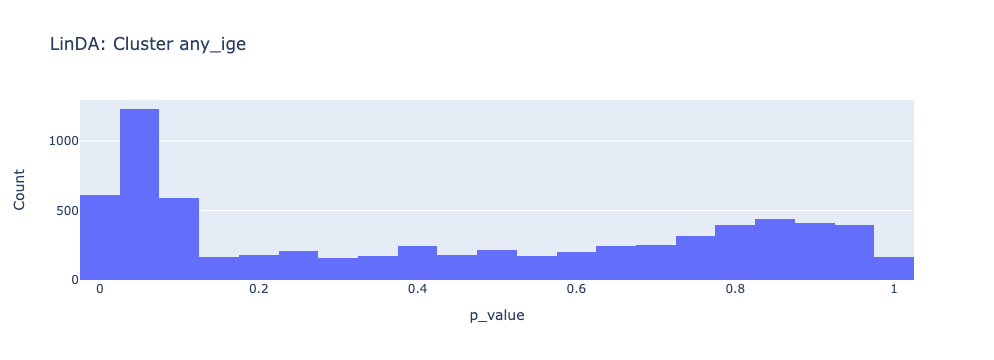

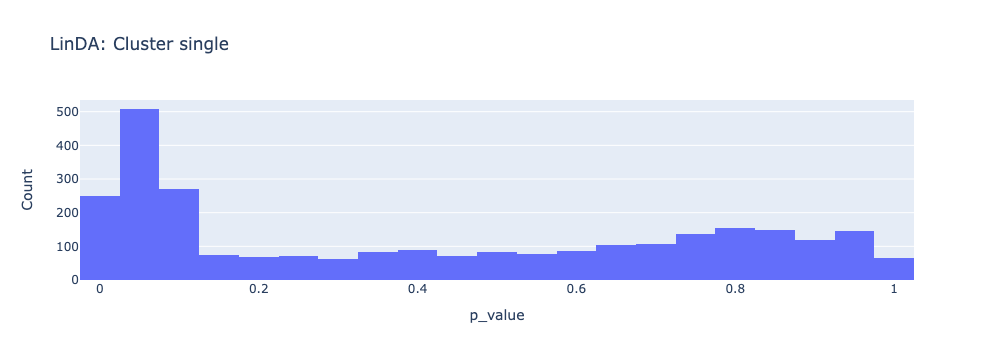

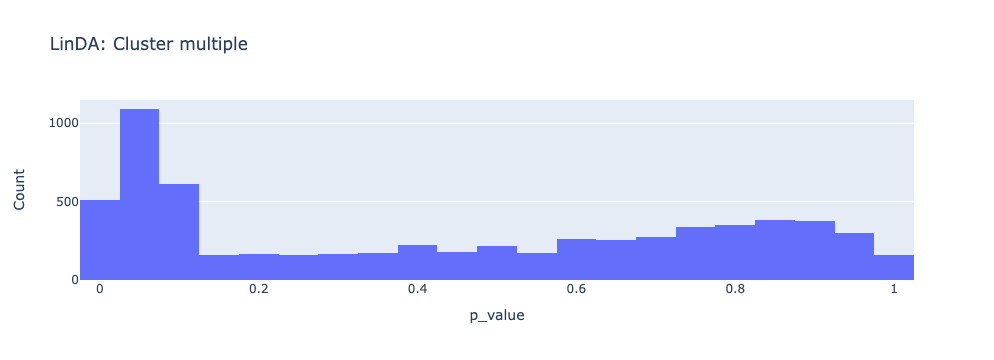

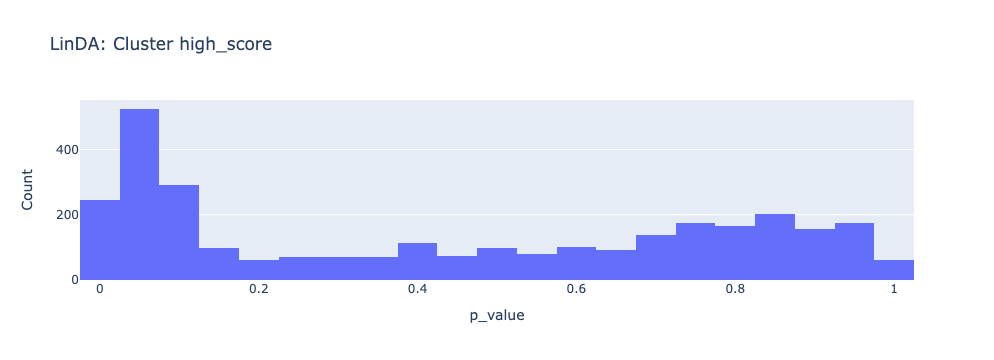

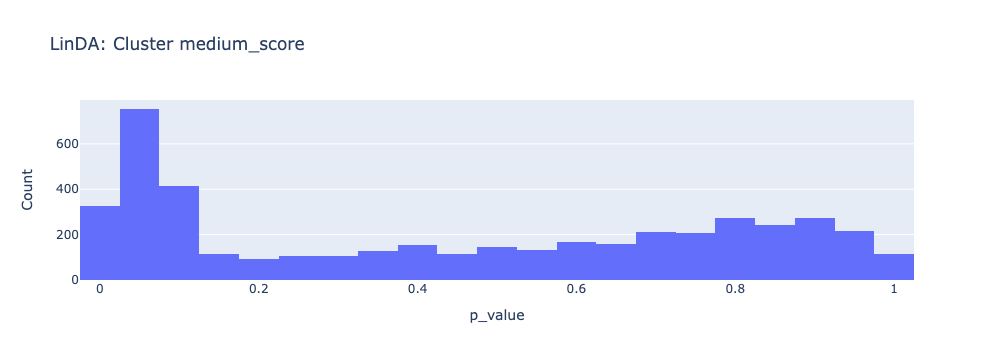

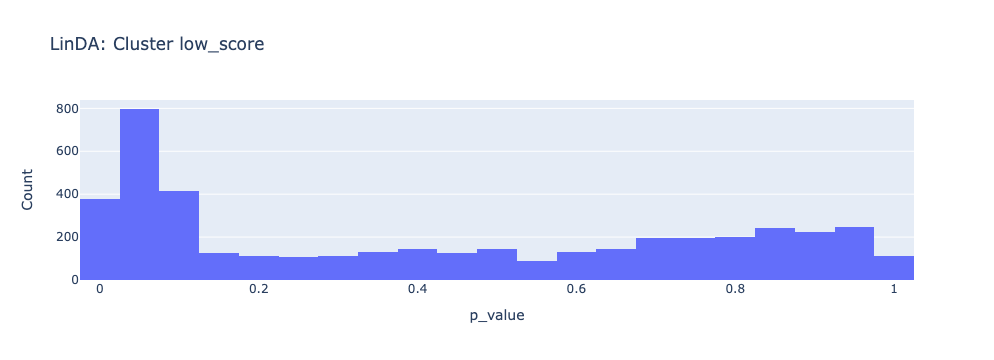

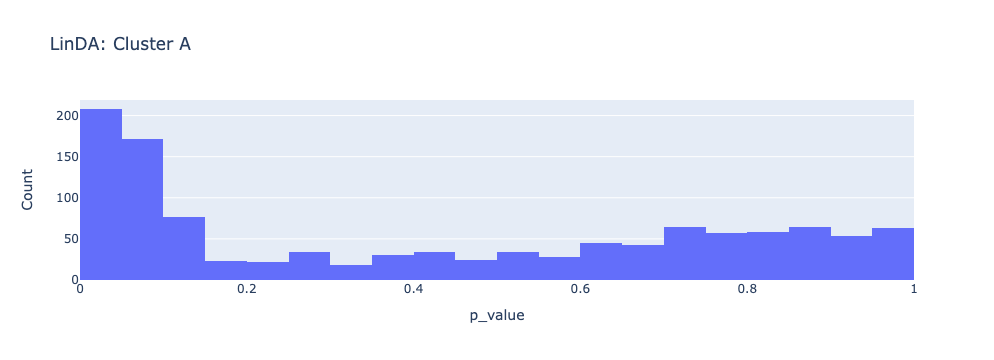

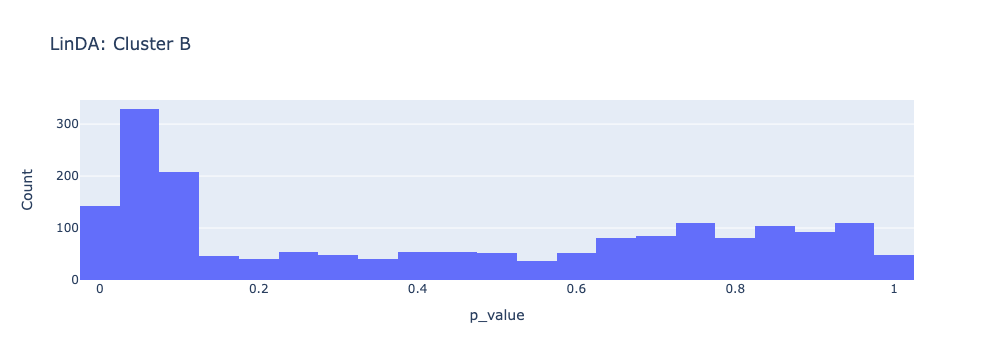

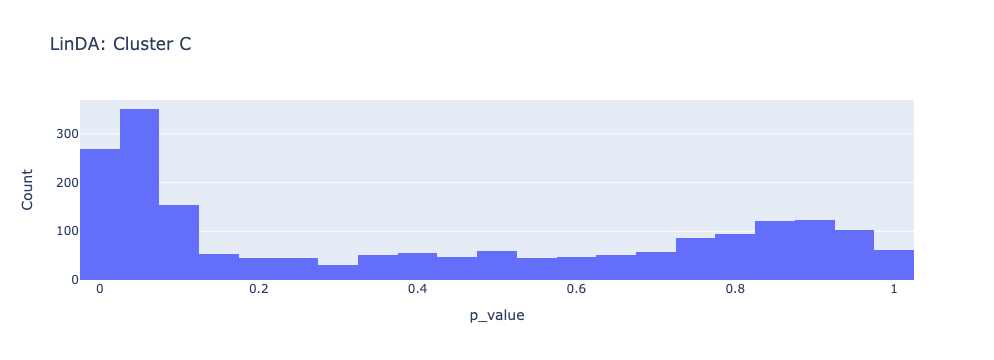

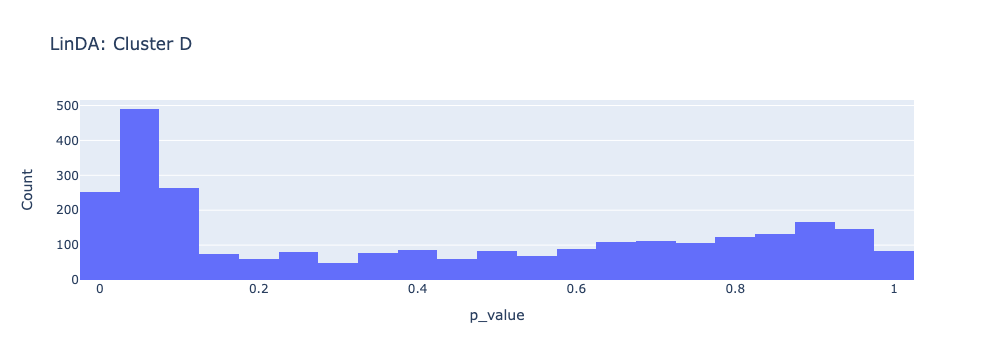

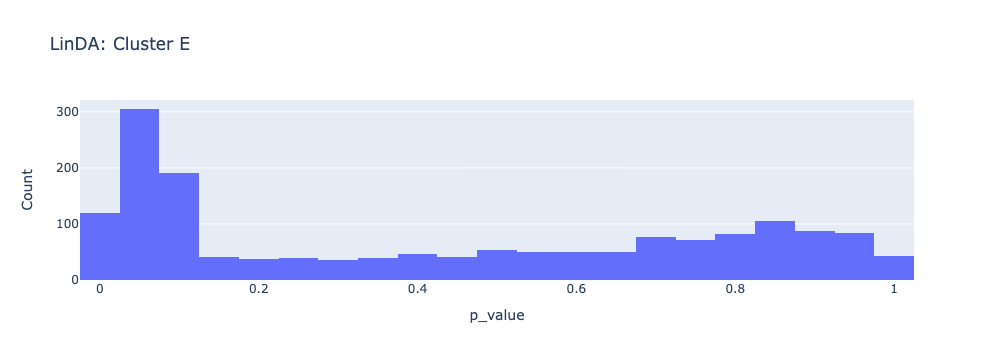

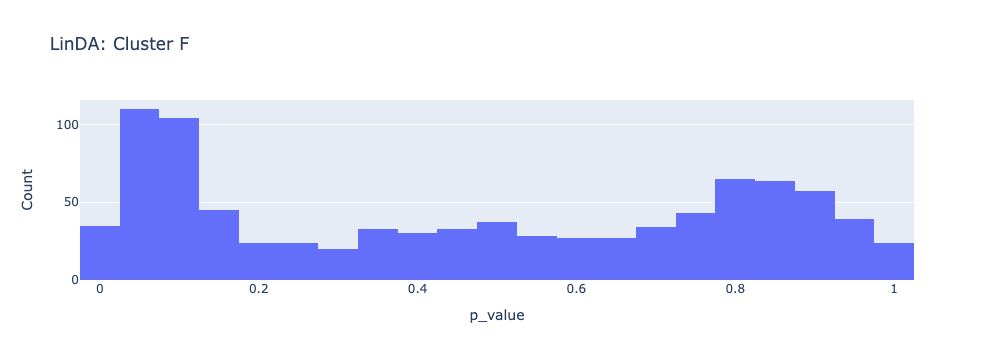

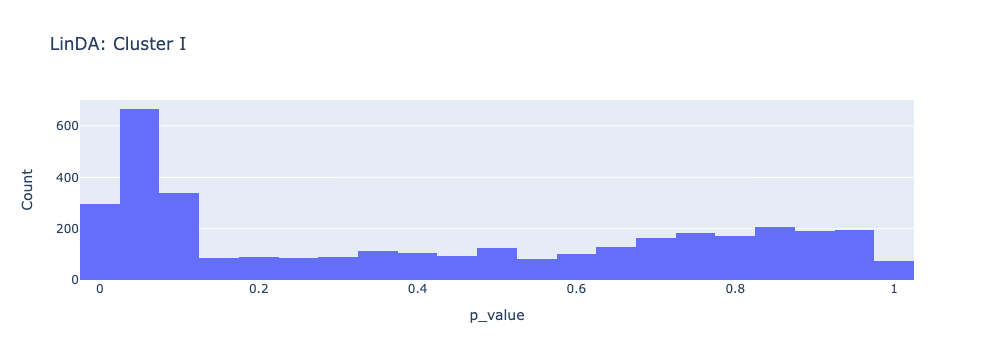

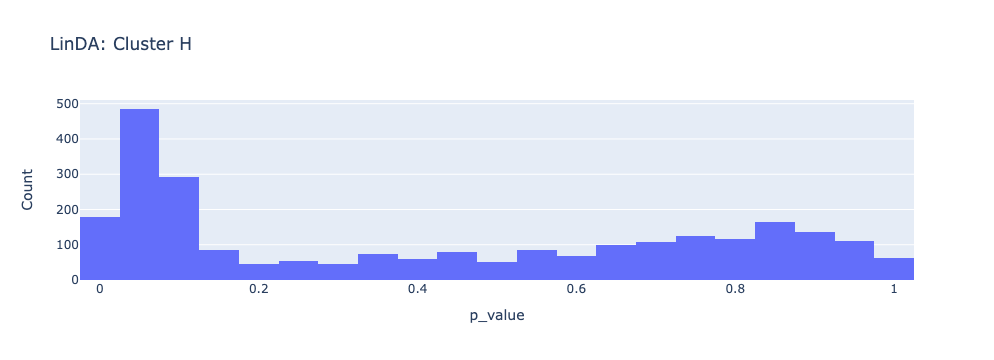

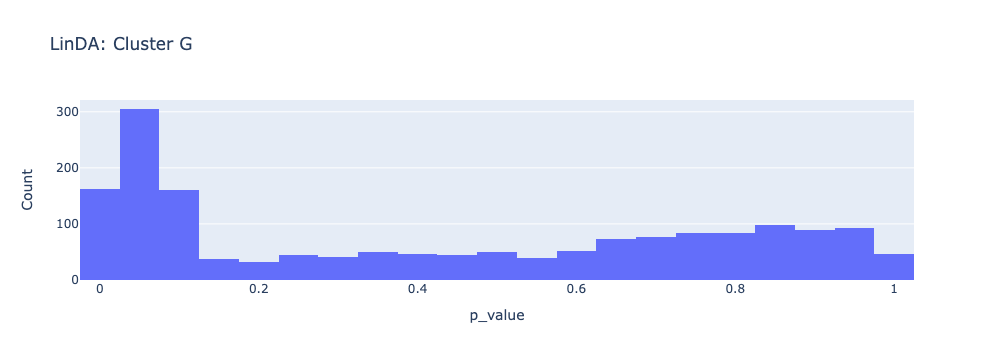

In [29]:
for cluster in allergy_status.keys():
    p_values_df = result_dict[cluster]['LinDA_results']['ASVs']['p_value']
    
    fig = go.Figure(data=[go.Histogram(x=p_values_df)])
    
    fig.update_layout(title=f'LinDA: Cluster {cluster}',
                      xaxis_title='p_value',
                      yaxis_title='Count')
    
    fig.show()

In [30]:
adjusted_results = dict()
FDR_rate = 0.05

for cluster, cluster_results in result_dict.items():
    adjusted_results[cluster] = {"LinDA_results": {}, "MW_results": {}}
    
    # Process LinDA results
    linda_results = cluster_results.get("LinDA_results", {})
    for taxa_rank, df in linda_results.items():
        adjusted_results[cluster]["LinDA_results"][taxa_rank] = perform_bh_correction_and_filter(df.copy(), alpha=FDR_rate)

In [31]:
taxonomic_levels = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]

combined_results = dict()
significance_threshold = 0.05

for lvl in taxonomic_levels:
    # Initialize the dictionary for the cluster if it doesn't exist
    if lvl not in combined_results:
        combined_results[lvl] = {}

    for cluster, results in adjusted_results.items():
        
        linda_results = results["LinDA_results"].get(lvl)
        
        if linda_results is not None and not linda_results.empty:
            print(f"\n ------------------------- LinDA q-value for cluster {cluster} at level {lvl}: ------------------------- \n")
            adjusted_pvalues = linda_results['adjusted_pvalue']
            
            combined_results[lvl][cluster] = adjusted_pvalues

            if lvl == "ASVs":
                taxa_name = adjusted_pvalues.to_frame().merge(taxa[['name']],
                                                              left_index=True, right_index=True)
                taxa_name.index = taxa_name['name']
                adjusted_pvalues = taxa_name['adjusted_pvalue']
                
            num_da_taxa = (adjusted_pvalues < significance_threshold).sum()
            print(f"Level: {lvl}, Cluster: {cluster} → DA taxa: {num_da_taxa}")

            print(adjusted_pvalues.to_string())


 ------------------------- LinDA q-value for cluster single at level species: ------------------------- 

Level: species, Cluster: single → DA taxa: 13
s__unknown_1347    0.049820
s__unknown_1974    0.044999
s__unknown_2039    0.044999
s__unknown_2077    0.044999
s__unknown_2317    0.044999
s__unknown_2359    0.044999
s__unknown_2362    0.044999
s__unknown_2461    0.044999
s__unknown_2554    0.044999
s__unknown_2689    0.044999
s__unknown_2736    0.044999
s__unknown_2764    0.044999
s__unknown_2894    0.044999

 ------------------------- LinDA q-value for cluster low_score at level species: ------------------------- 

Level: species, Cluster: low_score → DA taxa: 2
s__unknown_3065    0.035408
s__unknown_4613    0.035408

 ------------------------- LinDA q-value for cluster B at level species: ------------------------- 

Level: species, Cluster: B → DA taxa: 3
s__unknown_1800    0.048539
s__unknown_1851    0.048539
s__unknown_1934    0.048539

 ------------------------- LinDA q-value f

### DA Direction Heatmap

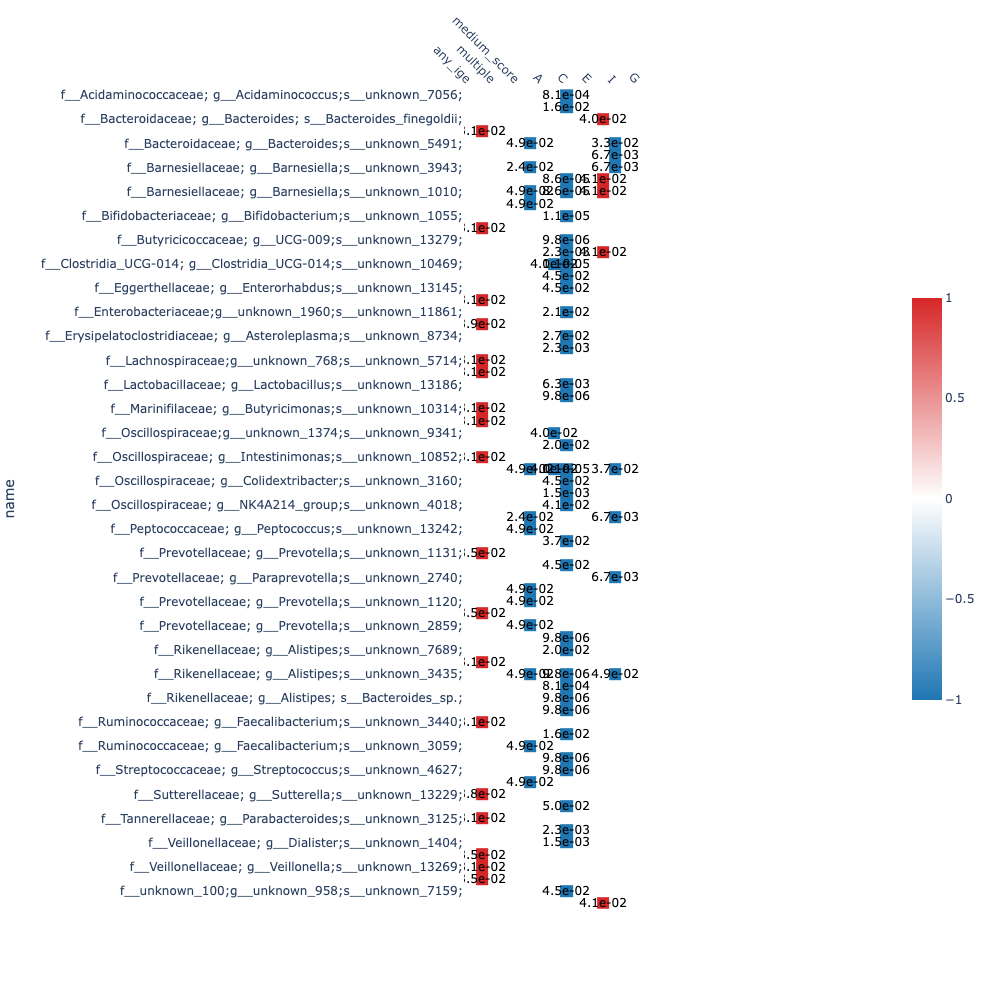

In [32]:
lvl = "ASVs"

# Initialize dataframes for direction and p-values
da_taxa = pd.DataFrame(combined_results[lvl])
da_direction_df = pd.DataFrame(index=da_taxa.index, columns=result_dict.keys())
da_pvalues_df = pd.DataFrame(index=da_taxa.index, columns=result_dict.keys())

# Efficiently fill direction and p-value columns
for cluster in da_direction_df.columns:
    effects = result_dict[cluster]["LinDA_results"].get(lvl, {}).get("effect", pd.Series())
    p_values = result_dict[cluster]["LinDA_results"].get(lvl, {}).get("adjusted_pvalue", pd.Series())
    da_direction_df[cluster] = effects.reindex(da_taxa.index, fill_value=0)
    da_pvalues_df[cluster] = p_values.reindex(da_taxa.index, fill_value=np.nan)

# Apply p-value threshold and set non-significant entries to NaN/0
da_direction_df[da_pvalues_df > 0.05] = 0
da_pvalues_df[da_pvalues_df > 0.05] = np.nan

# Join taxa information and extract 'family' for sorting
da_direction_df = da_direction_df.join(taxa[['name']]).set_index('name')
da_pvalues_df = da_pvalues_df.join(taxa[['name']]).set_index('name')

# Extract family information and sort both dataframes
for df in [da_direction_df, da_pvalues_df]:
    df['family'] = df.index.str.extract(r'f__([^;]+)', expand=False)
    df.sort_values('family', inplace=True)
    df.drop(columns=['family'], inplace=True)

### names up to family level    
da_direction_df.index = da_direction_df.index.str.split(';').str[4:].str.join(';')

# Prepare annotations (formatted p-values)
annotations = da_pvalues_df.applymap(lambda x: f"{x:.1e}" if pd.notna(x) else "")

# Custom red-white-blue colorscale
colorscale = [[0, '#1F77B4'], [0.5, 'white'], [1, '#D62728']]

# Create heatmap with annotations
fig = px.imshow(
    da_direction_df,
    color_continuous_scale=colorscale,
    text_auto=False  # Disable auto text to control annotation format
)

# Add text annotations for p-values
fig.update_traces(
    text=annotations.values,
    texttemplate='%{text}',  # Directly use the annotations
    textfont=dict(size=12, color='black'),
    hoverinfo='text'
)

# Update layout
fig.update_layout(
    width=1000,
    height=1000,
    plot_bgcolor='white',
    coloraxis_colorbar=dict(len=0.5)
)
fig.update_xaxes(side='top', tickangle=45)

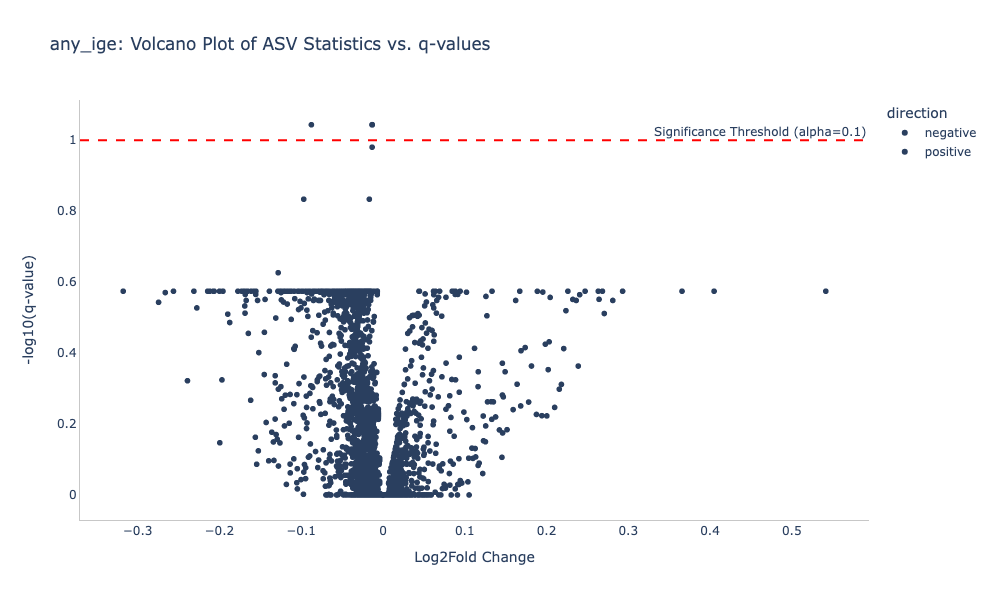

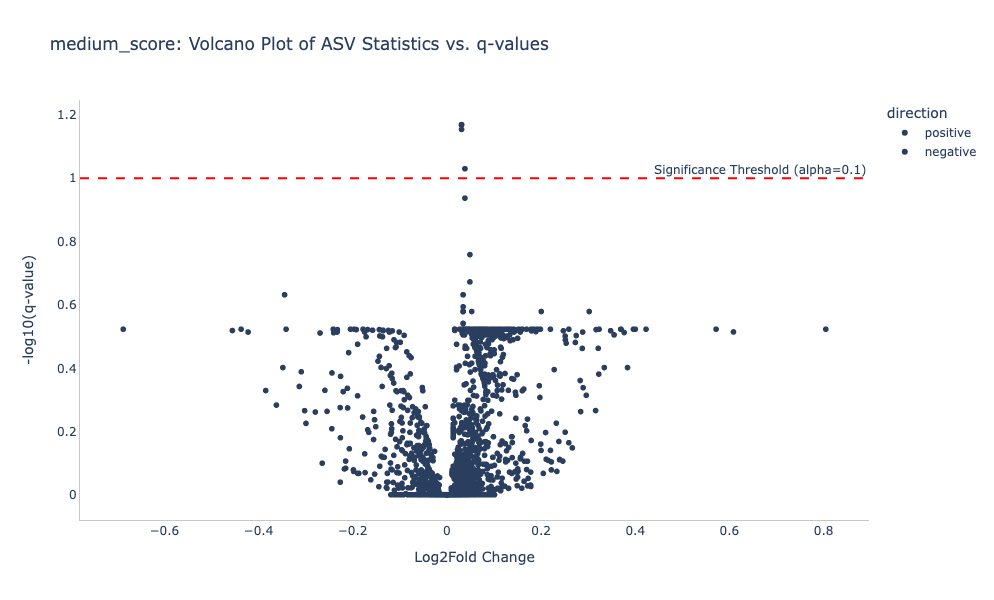

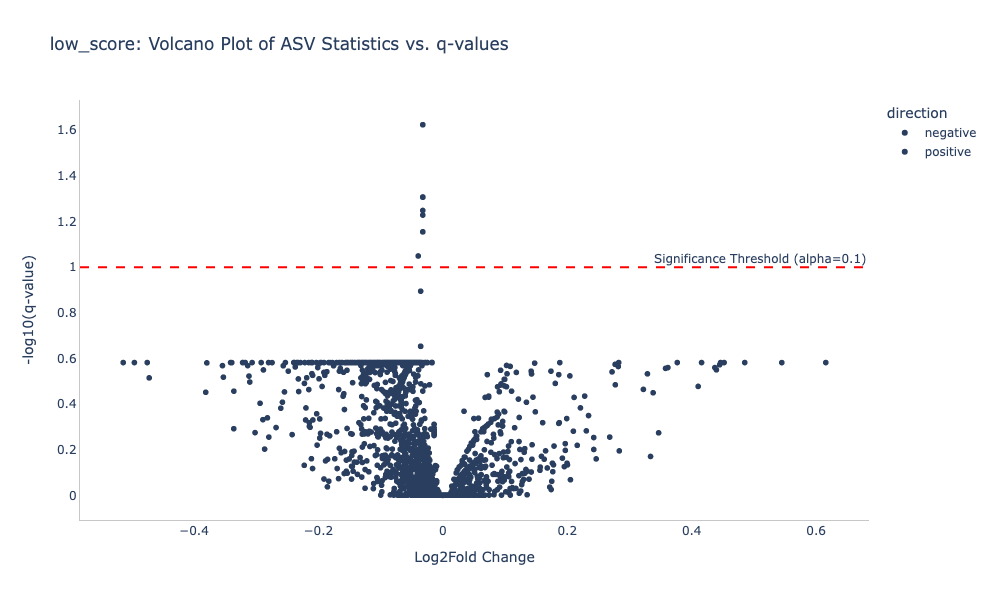

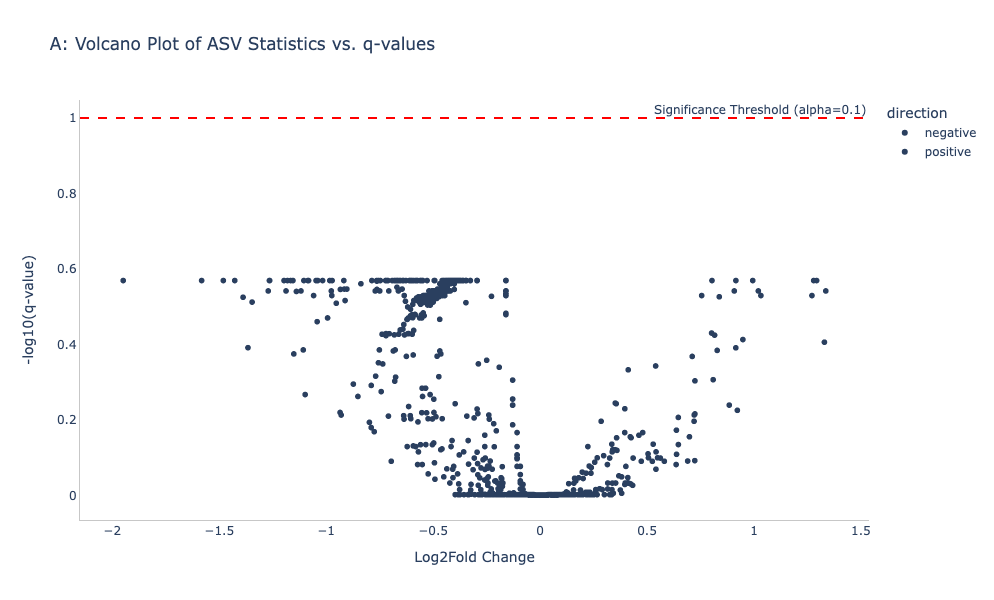

In [33]:
lvl = 'ASVs'

for cluster in ['any_ige', 'medium_score', 'low_score', 'A']:

    df = result_dict[cluster]['LinDA_results'][lvl].join(taxa['family'])

    volcano_df = pd.DataFrame({
        'lfc': df["lfc"],
        '-log10(q-value)': -np.log10(df['adjusted_pvalue']), # Calculate -log10 of q-values for the y-axis
        'name': df["family"],  # ASV index for hover text,
        'direction': np.where(df["obs_stat"] < 0, 'negative', 'positive')
    })

    # Create the volcano plot
    fig = px.scatter(
        volcano_df,
        x='lfc',
        y='-log10(q-value)',
        hover_name='name',
        color='direction',
        color_discrete_map={'negative': '#2A3F5F', 'positive': '#2A3F5F'},
        title=f'{cluster}: Volcano Plot of ASV Statistics vs. q-values',
        labels={'Statistic': 'lfc', '-log10(q-value)': '-log10(q-value)'},
        height=600,
        width=800
    )

    # Add a horizontal line at -log10(0.05) for significance threshold
    fig.add_hline(
        y=-np.log10(0.1),
        line=dict(color="red", width=2, dash="dash"),
        annotation_text="Significance Threshold (alpha=0.1)",
        annotation_position="top right"
    )

    # Customize layout
    fig.update_layout(
        xaxis_title='Log2Fold Change',
        yaxis_title='-log10(q-value)',
        plot_bgcolor='white',      
        paper_bgcolor='white',
        xaxis=dict(linecolor='#C7C7C7'), 
        yaxis=dict(linecolor='#C7C7C7')
    )

    fig.show()

In [35]:
selected_families = [
    "f__Lachnospiraceae;", 
    "f__Oscillospiraceae;", 
    "f__Bacteroidaceae;", 
    "f__Veillonellaceae;"
    # "f__Ruminococcaceae;",
    # "f__Rikenellaceae"
]

da_clusters = ['any_ige', 'medium_score', 'low_score', 'A']

tested_asv_set = set()
da_asv_set = set()

for cluster in da_clusters:
    tested_asv_set.update(result_dict[cluster]['counts']["ASVs"].index)
    da_asv_set.update(combined_results["ASVs"][cluster].index)

tested_asv_families = taxa.loc[taxa.index.isin(tested_asv_set), 'family']
da_asv_families = taxa.loc[taxa.index.isin(da_asv_set), 'family']

# Function to create pie chart data
def prepare_pie_data(asv_families, selected_families):
    family_counts = asv_families.value_counts()
    data = []
    for family in selected_families:
        count = family_counts.get(family, 0)
        fraction = count / len(asv_families)
        data.append({"family": family, "fraction": fraction})
    other_fraction = 1 - sum(x["fraction"] for x in data)
    data.append({"family": "Other", "fraction": other_fraction})
    return data

# Prepare data
tested_data = prepare_pie_data(tested_asv_families, selected_families)
da_data = prepare_pie_data(da_asv_families, selected_families)

# Plot both pies
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Family distribution of all tested ASVs', 'Family distribution of only DA ASVs'])

fig.add_trace(go.Pie(labels=[x['family'] for x in tested_data],
                     values=[x['fraction'] for x in tested_data],
                     hole=0.3), 1, 1)

fig.add_trace(go.Pie(labels=[x['family'] for x in da_data],
                     values=[x['fraction'] for x in da_data],
                     hole=0.3), 1, 2)

fig.update_layout(
    title_text="ASV Family Distribution",
    width=1000,
    height=500,
)

fig.show()

### Enrichment analysis

#### Genera

In [36]:
### import TAXSEA results
metabol_genus = pd.read_csv("data/TaxSEA_Metabolite_Producers_genus.csv", sep=",", low_memory=False)
metabol_genus

Taxon Set   
0        GutMGene: Producers of Trimethylamine oxide  \
1                      GutMGene: Producers of Serine   
2                GutMGene: Producers of l-Isoleucine   
3  GutMGene: Producers of 2-Imino-1-methylimidazo...   
4                     GutMGene: Producers of Proline   
5                    GutMGene: Producers of Creatine   

   Median rank of set members   P Value       FDR   
0                   -0.064957  0.064425  0.511655  \
1                    0.035680  0.335108  0.397203   
2                    0.035680  0.335456  0.397203   
3                   -0.034418  0.472995  0.355245   
4                    0.020703  0.542119  0.308858   
5                   -0.010865  0.672208  0.302098   

                                   Taxon Set Members  
0  Blautia, Escherichia-Shigella, Bifidobacterium...  
1  Faecalibacterium, Blautia, Ruminococcus, Dorea...  
2  Blautia, Ruminococcus, Dorea, Prevotella, Para...  
3  Faecalibacterium, Dorea, Bilophila, Succinivib...  
4  Blautia, Parabacteroides, Ruminococcus, Dorea,...  
5  Ruminococcus, Akkermansia, Lactobacillus, Mits...

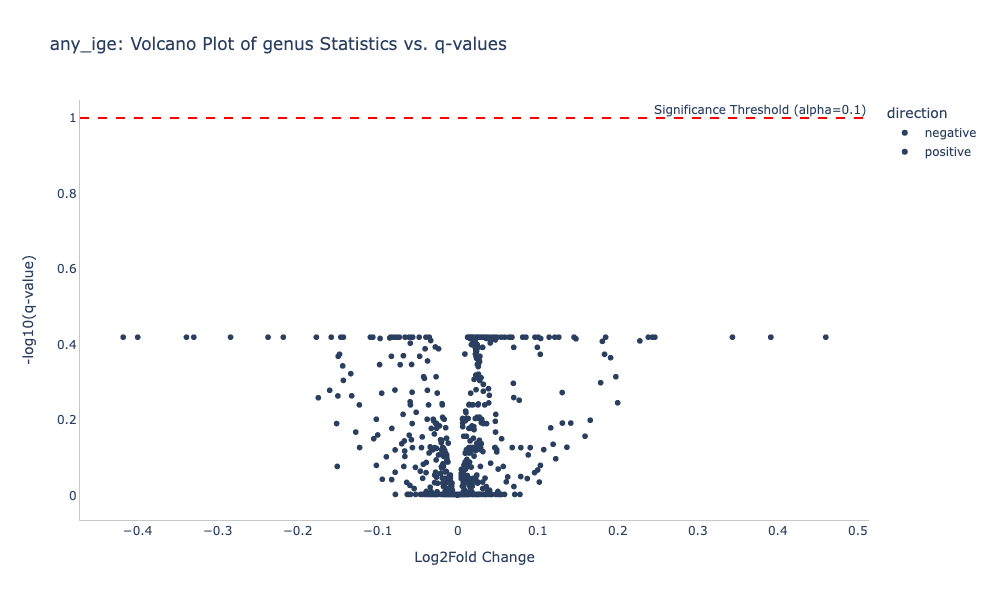

In [37]:
lvl = 'genus'

df = result_dict[cluster]['LinDA_results'][lvl].copy()

volcano_df = pd.DataFrame({
    'lfc': df["lfc"],
    '-log10(q-value)': -np.log10(df['adjusted_pvalue']), # Calculate -log10 of q-values for the y-axis
    'direction': np.where(df["obs_stat"] < 0, 'negative', 'positive')
})

# Create the volcano plot
fig = px.scatter(
    volcano_df,
    x='lfc',
    y='-log10(q-value)',
    hover_name=df.index,
    color='direction',
    color_discrete_map={'negative': '#2A3F5F', 'positive': '#2A3F5F'},
    title=f'{cluster}: Volcano Plot of {lvl} Statistics vs. q-values',
    labels={'Statistic': 'lfc', '-log10(q-value)': '-log10(q-value)'},
    height=600,
    width=800
)

# Add a horizontal line at -log10(0.05) for significance threshold
fig.add_hline(
    y=-np.log10(0.1),
    line=dict(color="red", width=2, dash="dash"),
    annotation_text="Significance Threshold (alpha=0.1)",
    annotation_position="top right"
)

# Customize layout
fig.update_layout(
    xaxis_title='Log2Fold Change',
    yaxis_title='-log10(q-value)',
    plot_bgcolor='white',      
    paper_bgcolor='white',
    xaxis=dict(linecolor='#C7C7C7'), 
    yaxis=dict(linecolor='#C7C7C7')
)

# Display the plot
fig.show()

# fig.write_image(f"plots/png/volcano_{cluster}.png")
# fig.write_image(f"plots/pdf/volcano_{cluster}.pdf")
# fig.write_html(f"plots/html/volcano_{cluster}.html")
# fig.write_image(f"plots/svg/volcano_{cluster}.svg")

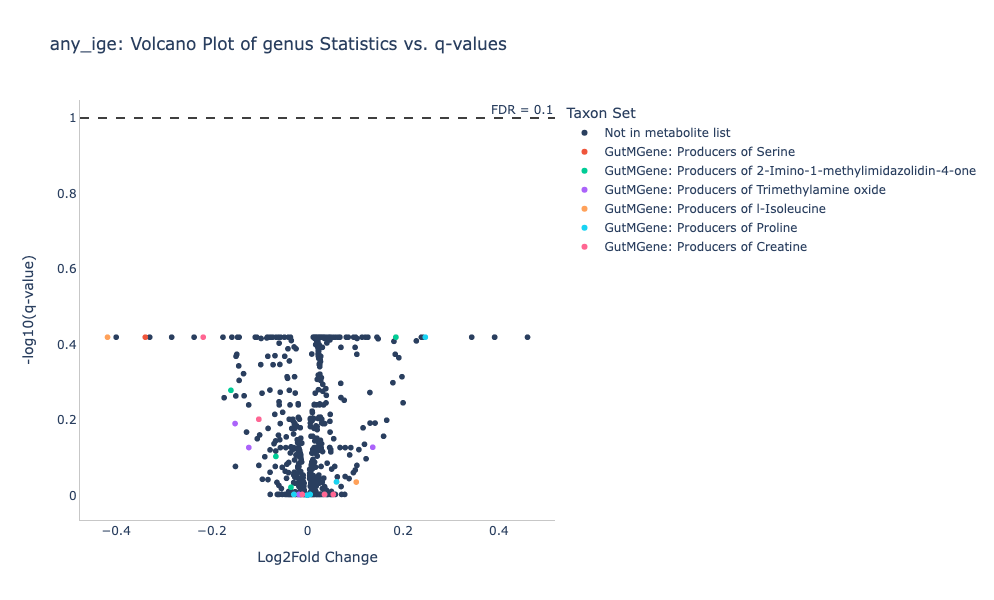

In [41]:
# Step 1: Create mapping from genus to taxon set
taxon_set_mapping = (
    metabol_genus[["Taxon Set", "Taxon Set Members"]]
    .assign(
        genus_list=lambda df: df["Taxon Set Members"].str.split(", ")
    )
    .explode("genus_list")
    .rename(columns={"genus_list": "genus"})
    .drop(columns="Taxon Set Members")
)

# Optional: strip any leading/trailing spaces
taxon_set_mapping["genus"] = taxon_set_mapping["genus"].str.strip()

# Step 2: Prepare volcano_df with cleaned genus
volcano_df_enriched = volcano_df.copy()
volcano_df_enriched["genus"] = (
    volcano_df_enriched.index.to_series()
    .str.replace("g__", "", regex=False)
    .str.rstrip(";")
)

# Step 3: Merge taxon set info
volcano_df_enriched = volcano_df_enriched.merge(
    taxon_set_mapping,
    on="genus",
    how="left"
)

# Step 4: Fill missing taxon set info for non-highlighted genera
volcano_df_enriched["Taxon Set"] = volcano_df_enriched["Taxon Set"].fillna("Not in metabolite list")

# Step 5: Plot
fig = px.scatter(
    volcano_df_enriched,
    x="lfc",
    y="-log10(q-value)",
    hover_name="genus",
    color="Taxon Set",
    color_discrete_map={'Not in metabolite list': '#2A3F5F'},
    title=f'{cluster}: Volcano Plot of {lvl} Statistics vs. q-values',
    labels={"lfc": "Log2Fold Change", "-log10(q-value)": "-log10(q-value)"},
    height=650,
    width=850
)

# Add significance threshold
fig.add_hline(
    y=-np.log10(0.1),
    line=dict(color="black", width=1.5, dash="dash"),
    annotation_text="FDR = 0.1",
    annotation_position="top right"
)

# Optional styling
fig.update_layout(
    xaxis_title="Log2Fold Change",
    yaxis_title="-log10(q-value)",
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(linecolor='#C7C7C7'),
    yaxis=dict(linecolor='#C7C7C7'),
    width=1000,
    height=600,
)

fig.show()

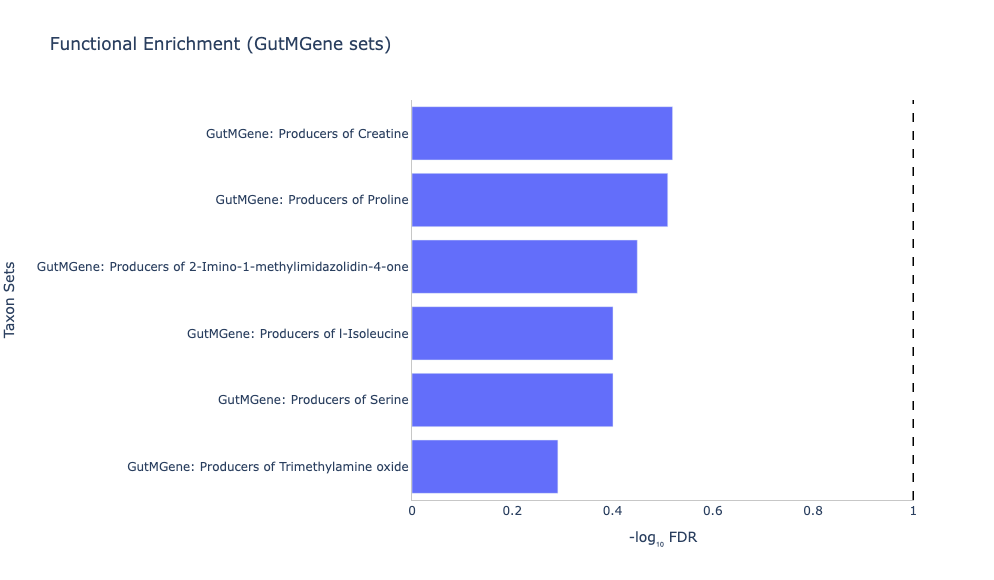

In [40]:
# Ensure FDR is numeric
metabol_genus["FDR"] = pd.to_numeric(metabol_genus["FDR"], errors="coerce")

# Compute -log10 FDR
metabol_genus["-log10 FDR"] = -np.log10(metabol_genus["FDR"])

# Sort by enrichment score if desired (optional)
metabol_genus_sorted = metabol_genus.sort_values("-log10 FDR", ascending=True)

# Create horizontal bar plot
fig = px.bar(
    metabol_genus_sorted,
    x="-log10 FDR",
    y="Taxon Set",
    orientation='h',
    title="Functional Enrichment (GutMGene sets)",
    labels={"-log10 FDR": "-log₁₀ FDR", "Taxon Set": "Taxon Sets"},
    height=400 + 30 * len(metabol_genus_sorted)
)

# Add dashed significance threshold line at FDR = 0.1
fig.add_vline(
    x=-np.log10(0.1),
    line=dict(color="black", width=1.5, dash="dash"),
)

# Clean layout
fig.update_layout(
    xaxis_title="-log₁₀ FDR",
    yaxis_title="Taxon Sets",
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(linecolor='#C7C7C7'),
    yaxis=dict(linecolor='#C7C7C7')
)

fig.show()

#### Species

In [42]:
# --- 1. Load data ---
metabol_species = pd.read_csv("data/TaxSEA_Metabolite_Producers_species.csv", sep=",", low_memory=False)

# --- 2. Define compound → class mapping ---
compound_class_map = {
    'Acetate': 'SCFAs',
    'Propionate': 'SCFAs',
    'Butyrate': 'SCFAs',
    'Isovaleric acid': 'SCFAs',
    'Taurocholic acid': 'Bile Acids',
    'Glycocholic acid': 'Bile Acids',
    'TMAO': 'Amino Acid Derivatives',
    'GABA': 'Amino Acid Derivatives',
    'Serine': 'Amino Acid Derivatives',
    'Equol': 'Amino Acid Derivatives',
    'Indole': 'Amino Acid Derivatives',
    'Daidzein': 'Amino Acid Derivatives',
    '3IAA': 'Amino Acid Derivatives',
    'Tyramine': 'Amino Acid Derivatives',
    'Vitamin A': 'Vitamins',
    'Vitamin K': 'Vitamins',
    'Folic acid': 'Vitamins',
    'Succinate': 'Others',
    'L-carnitine': 'Others',
    'Dimethylamine': 'Others',
    '4-Hydroxyphenylacetic acid': 'Others'
}

# --- 3. Extract compound name from 'Taxon Set' ---
metabol_species["Compound"] = metabol_species["Taxon Set"].str.extract(r": Producers of (.+)")

# --- 4. Map to class ---
metabol_species["Class"] = metabol_species["Compound"].map(compound_class_map)

# --- 5. Fill missing values with "Others" (standardize)
metabol_species["Class"] = metabol_species["Class"].fillna("Others")

# --- 6. Optional: Check for unmapped compounds ---
unmapped = metabol_species[~metabol_species["Compound"].isin(compound_class_map)]
if not unmapped.empty:
    print("⚠️ Warning: These compounds were not in the mapping and defaulted to 'Others':")
    print(unmapped["Compound"].unique())

# --- 7. Final result ---
print(metabol_species.head())

⚠️ Warning: These compounds were not in the mapping and defaulted to 'Others':
['Butyric acid' 'Dimethylamine ']
                                           Taxon Set   
0  GutMGene: Producers of 4-Hydroxyphenylacetic acid  \
1                     GutMGene: Producers of Acetate   
2                       GutMGene: Producers of Equol   
3                  MiMeDB: Producers of Butyric acid   
4                          MiMeDB: Producers of TMAO   

   Median rank of set members   P Value       FDR   
0                    0.025419  0.059978  0.558065  \
1                    0.018929  0.121717  0.328784   
2                   -0.036865  0.234769  0.337814   
3                   -0.003182  0.433005  0.130108   
4                    0.008175  0.471548  0.273297   

                                   Taxon Set Members   
0  Bifidobacterium longum, Bacteroides eggerthii,...  \
1  Bacteroides massiliensis, Bifidobacterium long...   
2  Bacteroides vulgatus, Bacteroides stercoris, B...   
3  Bact

### Cluster vs. Cluster

In [122]:
result_dict_clusters = dict()
freq_threshold = 0
seed = 42

# Test with only the first two clusters
test_clusters = cluster_df['cluster'].unique()[:2]

# Iterate through each cluster
for cluster_1 in cluster_df['cluster'].unique():
    for cluster_2 in cluster_df['cluster'].unique():
        # Skip if comparing the same cluster
        if cluster_1 == cluster_2:
            continue
            
        # Enforce a consistent order for the key
        key = f"{sorted([cluster_1, cluster_2])[0]}_{sorted([cluster_1, cluster_2])[1]}"
        
        # Skip if this comparison has already been made
        if key in result_dict_clusters:
            continue
            
        print(f"------------------------- Comparing {cluster_1} and {cluster_2} clusters ------------------------- \n")
        
        # Select samples from both clusters
        selected_samples_1 = cluster_df[cluster_df['cluster'] == cluster_1].index
        selected_samples_2 = cluster_df[cluster_df['cluster'] == cluster_2].index

        # Test and control samples for the comparison
        test_samples = vis_ige.loc[vis_ige.index.isin(selected_samples_1.values)]
        ctlr_samples = vis_ige.loc[vis_ige.index.isin(selected_samples_2.values)]
        
        
        if pair_matching:

            #################### PAIR-MATCHING ##############################

            test_samples_new_column = pd.DataFrame({'W': np.ones(test_samples.shape[0])})
            ctlr_samples_new_column = pd.DataFrame({'W': np.zeros(ctlr_samples.shape[0])})

            test_samples = pd.concat([test_samples.reset_index(drop=False), test_samples_new_column], axis=1)
            ctlr_samples = pd.concat([ctlr_samples.reset_index(drop=False), ctlr_samples_new_column], axis=1)

            df = pd.concat([test_samples, ctlr_samples])
            df.set_index('u3_16s_id', inplace=True)

            ### join with covariates and drop missing samples
            df = df.join(covariates[['u3csex']])

            # ### drop samples where we don't know age, sex or BMI
            # df.dropna(inplace=True)

            df["is_treated"] = df["W"].astype(bool)
            df["pair_nb"] = np.nan

            # Set the thresholds for each covariate (p), default is Inf (i.e. no matching)
            thresholds =  np.empty((df.shape[1], ))
            thresholds[:] = np.nan

            column_thresholds = {"u3csex": 0}

            # Set thresholds using the dictionary
            for column_name, threshold_value in column_thresholds.items():

                if column_name not in df.columns:
                    continue

                column_index = df.columns.get_loc(column_name)
                thresholds[column_index] = threshold_value

            treated_units = df[df["is_treated"] == True]
            control_units = df[df["is_treated"] == False]

            N_treated, N_control = treated_units.shape[0], control_units.shape[0]
            print("Number of treated units: {0}".format(N_treated))
            print("Number of control units: {0}".format(N_control))

            # Optional weights for each covariate when computing the distances
            # WARNING: the order of the items in scaling needs to be the same as the order of the covariates (i.e. columns)
            scaling =  np.ones((df.shape[1], ), dtype=int) 

            discrepancies = discrepancyMatrix(treated_units, control_units, thresholds, scaling)

            g, pairs_dict = construct_network(discrepancies, N_treated, N_control)
            matched_df = process_matched_pairs(pairs_dict, treated_units, control_units)

            print("Number of pairs: {0}".format(len(matched_df.W)))

            test_samples = matched_df[matched_df.W == 1]
            ctlr_samples = matched_df[matched_df.W == 0]

        else:
            #################### RANDOM SAMPLING ##############################
            class_size = test_samples.shape[0]
            ctlr_samples = ctlr_samples.sample(n=class_size, random_state=seed)
        
        print("Cluster 1 (Test): {0}, Cluster 2 (Control): {1}".format(test_samples.shape[0], ctlr_samples.shape[0]))
        
        # Create a dataframe to hold labels for the test
        result = pd.DataFrame(index=test_samples.index.union(ctlr_samples.index))
        result['w'] = 1  # Label cluster_1 samples as 1 (test)
        result.loc[ctlr_samples.index, 'w'] = 0  # Label cluster_2 samples as 0 (control)

        # Filter ASV table by selected sample IDs
        str_sample_ids = set(result.index.astype(str))
        ASV_table = asv.loc[:, asv.columns.isin(str_sample_ids)]    
        asv_top99_samples, asv_samples_ids = filter_and_process_asv_table(ASV_table, freq_threshold=freq_threshold)
        
        # Generate taxa dictionaries for comparison
        taxa_dict = generate_taxa_dict(asv=asv_top99_samples, taxa=taxa)
        del taxa_dict["name"]
        for level in taxa_dict.keys():
            print("{0} count table shape: {1}".format(level, taxa_dict[level].shape))
        
        # Overlap 16S and IgE samples
        sample_ids = asv_top99_samples.columns.astype(int)
        w = result[result.index.isin(sample_ids)]
        
        # Run LinDA
        linda_stats = calculate_obs_stat_and_pvalues(taxa_dict, w)
        print("------------------------- LinDA is DONE ------------------------- \n")
        
        # Run Mann-Whitney U test
        mann_whitney_results = {}
        for level, taxa_table in taxa_dict.items():
            print(f"Performing Mann-Whitney U test at level: {level}")

            stats_results = []
            for taxa_name in taxa_table.index:
                test_values = taxa_table.loc[taxa_name, test_samples.index.astype(str)]
                control_values = taxa_table.loc[taxa_name, ctlr_samples.index.astype(str)]

                # Perform Mann-Whitney U test
                stat, p_value = mannwhitneyu(test_values, control_values, alternative='two-sided')
                stats_results.append({"taxa": taxa_name, "obs_stat": stat, "p_value": p_value})

            # Convert to DataFrame
            mann_whitney_results[level] = pd.DataFrame(stats_results).set_index("taxa")

        print("------------------------- MW is DONE ------------------------- \n")
        
        comparison_key = f"{cluster_1}_{cluster_2}"
        result_dict_clusters[comparison_key] = {
            "counts": taxa_dict, 
            "LinDA_results": linda_stats,
            "MW_results": mann_whitney_results
        }

# # Save the results
# with open("data/DA_cluster_comparisons_results.pkl", "wb") as f:
#     pkl.dump(result_dict_clusters, f)

------------------------- Comparing A and B clusters ------------------------- 

Number of treated units: 12
Number of control units: 24
Number of pairs: 22
Cluster 1 (Test): 11, Cluster 2 (Control): 11
domain count table shape: (2, 22)
phylum count table shape: (12, 22)
class count table shape: (18, 22)
order count table shape: (38, 22)
family count table shape: (83, 22)
genus count table shape: (352, 22)
species count table shape: (1132, 22)
ASVs count table shape: (1219, 22)
domain
2 22
(22, 1)
phylum
12 22
(22, 1)
class
18 22
(22, 1)
order
38 22
(22, 1)
Pseudo-count approach is used.
family
83 22
(22, 1)
Pseudo-count approach is used.
genus
352 22
(22, 1)
Pseudo-count approach is used.
species
1132 22
(22, 1)
Pseudo-count approach is used.
ASVs
1219 22
(22, 1)
Pseudo-count approach is used.
------------------------- LinDA is DONE ------------------------- 

Performing Mann-Whitney U test at level: domain
Performing Mann-Whitney U test at level: phylum
Performing Mann-Whitney U test

In [33]:
### read the DA results
with open("data/DA_cluster_comparisons_results.pkl", "rb") as f:
    result_dict_clusters = pkl.load(f)

# Check the structure of the loaded dictionary
print(type(result_dict_clusters))
print(result_dict_clusters.keys())  # Print top-level keys

<class 'dict'>
dict_keys(['A_B', 'A_C', 'A_D', 'A_E', 'A_F', 'A_I', 'A_H', 'A_G', 'B_C', 'B_D', 'B_E', 'B_F', 'B_I', 'B_H', 'B_G', 'C_D', 'C_E', 'C_F', 'C_I', 'C_H', 'C_G', 'D_E', 'D_F', 'D_I', 'D_H', 'D_G', 'E_F', 'E_I', 'E_H', 'E_G', 'F_I', 'F_H', 'F_G', 'I_H', 'I_G', 'H_I', 'H_G', 'G_I', 'G_H'])


In [34]:
adjusted_results_clusters = dict()
FDR_rate = 0.05

for cluster, cluster_results in result_dict_clusters.items():
    adjusted_results_clusters[cluster] = {"LinDA_results": {}, "MW_results": {}}
    
    # Process LinDA results
    linda_results = cluster_results.get("LinDA_results", {})
    for taxa_rank, df in linda_results.items():
        adjusted_results_clusters[cluster]["LinDA_results"][taxa_rank] = perform_bh_correction_and_filter(df.copy(), alpha=FDR_rate)
    
    # Process Mann-Whitney results
    mw_results = cluster_results.get("MW_results", {})
    for taxa_rank, df in mw_results.items():
        adjusted_results_clusters[cluster]["MW_results"][taxa_rank] = perform_bh_correction_and_filter(df.copy(), alpha=FDR_rate)